In [1]:
#Imported libs
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from tqdm import tqdm
import cv2
import pandas as pd
import os
import random

#from hyperas import optim
#from hyperas.distributions import choice, uniform
#from hyperopt import Trials, STATUS_OK, tpe

Using TensorFlow backend.


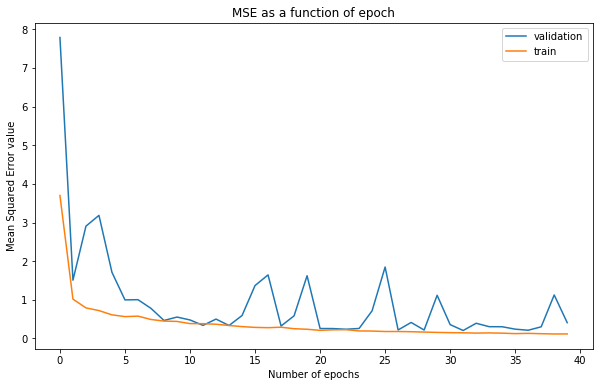

In [6]:
import pickle
file = open('history.pickle','rb')
data = pickle.load(file)
file.close()

val_loss,train_loss = data['val_loss'],data['loss']

plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(val_loss)),val_loss,label='validation')
plt.plot(np.arange(0,len(val_loss)),train_loss,label='train')
plt.xlabel('Number of epochs')
plt.ylabel('Mean Squared Error value')
plt.title('MSE as a function of epoch')
plt.legend()
plt.show()

In [2]:
def get_labels(file):
    with open(file,'r') as f:
        lines = f.readlines()
        return np.array([line.strip().split() for line in lines])
    
def index_process(flo):
    below = math.floor(flo)
    top = math.ceil(flo)
    
    result = np.zeros(5)
    result[below-1] = top-round(flo)
    result[top-1] = round(flo)-below
    
    return result

#loading of images and labels
#Cross validation was made by the dataset provider
PATH = 'Beau/train_test_files/split60/'
train_labels = get_labels(PATH+'train.txt')
test_labels = get_labels(PATH+'test.txt')

PATH2 = 'Beau/Images/'
X_pre_train = [cv2.imread(PATH2+file,0) for file in tqdm(train_labels[:,0])]
X_train = np.array([cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA) for img in X_pre_train])

X_pre_test = [cv2.imread(PATH2+file,0) for file in tqdm(test_labels[:,0])]
X_test = np.array([cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA) for img in X_pre_test])

y_train = np.array([float(flo) for flo in train_labels[:,1]])
y_test = np.array([float(flo) for flo in test_labels[:,1]])

100%|██████████| 2200/2200 [00:01<00:00, 1329.39it/s]


In [3]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
X_train.shape,y_train.shape

((3300, 160, 160, 1), (3300,))

In [37]:
def data():
    def get_labels(file):
        with open(file,'r') as f:
            lines = f.readlines()
            return np.array([line.strip().split() for line in lines])
    
    def index_process(flo):
        below = math.floor(flo)
        top = math.ceil(flo)

        result = np.zeros(5)
        result[below-1] = top-round(flo)
        result[top-1] = round(flo)-below

        return result

    #loading of images and labels
    #Cross validation was made by the dataset provider
    PATH = 'Beau/train_test_files/split60/'
    train_labels = get_labels(PATH+'train.txt')
    test_labels = get_labels(PATH+'test.txt')

    PATH2 = 'Beau/Images/'
    X_pre_train = [cv2.imread(PATH2+file,0) for file in tqdm(train_labels[:,0])]
    X_train = np.array([cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA) for img in X_pre_train])

    X_pre_test = [cv2.imread(PATH2+file,0) for file in tqdm(test_labels[:,0])]
    X_test = np.array([cv2.resize(img,(160,160),interpolation=cv2.INTER_AREA) for img in X_pre_test])

    #y_train = np.array([index_process(float(flo)) for flo in train_labels[:,1]])
    #y_test = np.array([index_process(float(flo)) for flo in test_labels[:,1]])
    
    y_train = np.array([float(flo) for flo in train_labels[:,1]])
    y_test = np.array([float(flo) for flo in test_labels[:,1]])
    
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
    
    return X_train,X_test,y_train,y_test

In [4]:
class Beau:
    def __init__(self):

        self.model = Sequential()

        #1st 2dConvolutional Layer
        self.model.add(Conv2D(64, (3, 3), padding='same', input_shape=(160, 160, 1)))
        self.model.add(Activation('relu'))

        #1st 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))

        #2nd 2dConvolutional Layer
        self.model.add(Conv2D(64, (3, 3), padding='same'))
        self.model.add(Activation('relu'))

        #2nd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))

        #3rd 2dConvolutional Layer
        self.model.add(Conv2D(128, (5, 5), padding='same'))
        self.model.add(Activation('relu'))

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        #4th 2dConvolutional Layer
        self.model.add(Conv2D(128, (5, 5), padding='same'))
        self.model.add(Activation('relu'))

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        #5th 2dConvolutional Layer
        self.model.add(Conv2D(256, (3, 3), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        #3rd 2dMaxPool Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2)))  
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        
        #6th 2dConvolutional Layer
        self.model.add(Conv2D(512, (5, 5), padding='same'))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(Flatten())

        #1st FC Layer
        self.model.add(Dense(256))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.25))
        
        #2nd FC Layer
        self.model.add(Dense(512))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.25))

        # Output layer
        self.model.add(Dense(1))
        self.model.add(Activation('relu'))

        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
        self.model.summary()

In [ ]:
model = Beau().model
history = model.fit(X_train, y_train,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 160, 160, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 80, 80, 64)       

Epoch 16/100
3300/3300 [==============================] - 234s 71ms/step - loss: 0.3756 - mean_squared_error: 0.3756 - val_loss: 0.2835 - val_mean_squared_error: 0.2835
Epoch 17/100
3300/3300 [==============================] - 233s 71ms/step - loss: 0.3996 - mean_squared_error: 0.3996 - val_loss: 0.2460 - val_mean_squared_error: 0.2460
Epoch 18/100
3300/3300 [==============================] - 236s 71ms/step - loss: 0.4025 - mean_squared_error: 0.4025 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 19/100
2560/3300 [======================>.......] - ETA: 44s - loss: 0.3957 - mean_squared_error: 0.3957

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
model.save('beau.h5')

In [22]:
def create_model(X_train,X_test,y_train,y_test):
    
    model = Sequential()

    #1st 2dConvolutional Layer
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(160, 160, 1)))
    model.add(Activation('relu'))

    #1st 2dMaxPool Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0,1)}}))

    #2nd 2dConvolutional Layer
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    #2nd 2dMaxPool Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0,1)}}))

    #3rd 2dConvolutional Layer
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(Activation('relu'))

    #3rd 2dMaxPool Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0,1)}}))

    #4th 2dConvolutional Layer
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(Activation('relu'))

    #3rd 2dMaxPool Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0,1)}}))

    #5th 2dConvolutional Layer
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    #3rd 2dMaxPool Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    model.add(BatchNormalization())
    model.add(Dropout({{uniform(0,1)}}))

    #6th 2dConvolutional Layer
    model.add(Conv2D(512, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Flatten())

    #1st FC Layer
    model.add(Dense({{choice([256, 512])}}))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,1)}}))

    #2nd FC Layer
    model.add(Dense({{choice([256, 512])}}))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,1)}}))

    # Output layer
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    result = model.fit(X_train, y_train,
            batch_size={{choice([64, 128])}},
            epochs=100,
            verbose=1,
            validation_data=(X_test, y_test))

    validation_acc = np.amax(result.history['val_accuracy']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [23]:
best_run, best_model = optim.minimize(model=create_model,
                                        data=data,
                                        algo=tpe.suggest,
                                        max_evals=5,
                                        trials=Trials(),
                                        notebook_name='beauty')

  4%|▍         | 139/3300 [00:00<00:02, 1381.74it/s]

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import time
except:
    pass

try:
    import math
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
except:
    pass

try:
    from keras.models import Model, Sequential
except:
    pass

try:
    from keras.models import model_from_json
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    import cv2
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import os
except:
    pass

try:
    import random
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

>>> Hyperas sear

100%|██████████| 2200/2200 [00:01<00:00, 1314.83it/s]


Train on 3300 samples, validate on 2200 samples    
Epoch 1/100                                        
 128/3300 [>.............................]         
 - ETA: 2:12 - loss: 2.2250 - accuracy: 0.2188     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:39 - loss: 2.3214 - accuracy: 0.1719     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:25 - loss: 2.3027 - accuracy: 0.1823     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:18 - loss: 2.2683 - accuracy: 0.1797     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:12 - loss: 2.2168 - accuracy: 0.1891     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:08 - loss: 2.2029 - accuracy: 0.2070     
                 

Epoch 3/100                                        
 128/3300 [>.............................]         
 - ETA: 1:17 - loss: 1.4310 - accuracy: 0.3828     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:15 - loss: 1.4753 - accuracy: 0.4141     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:11 - loss: 1.5048 - accuracy: 0.4245     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:08 - loss: 1.4978 - accuracy: 0.4238     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:05 - loss: 1.4735 - accuracy: 0.4234     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:02 - loss: 1.4825 - accuracy: 0.4115     
                                                  
 896/3300 [=======

Epoch 7/100                                        
 128/3300 [>.............................]         
 - ETA: 1:18 - loss: 1.3411 - accuracy: 0.3438     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:15 - loss: 1.2683 - accuracy: 0.3633     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:11 - loss: 1.2829 - accuracy: 0.3776     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:07 - loss: 1.3264 - accuracy: 0.3711     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:03 - loss: 1.3612 - accuracy: 0.3609     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:00 - loss: 1.3643 - accuracy: 0.3633     
                                                  
 896/3300 [=======

Epoch 11/100                                       
 128/3300 [>.............................]         
 - ETA: 1:14 - loss: 1.2943 - accuracy: 0.4531     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:10 - loss: 1.3023 - accuracy: 0.4102     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:08 - loss: 1.2840 - accuracy: 0.4219     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:07 - loss: 1.2701 - accuracy: 0.4082     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:04 - loss: 1.2782 - accuracy: 0.4078     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:01 - loss: 1.2790 - accuracy: 0.4167     
                                                  
 896/3300 [=======

Epoch 15/100                                       
 128/3300 [>.............................]         
 - ETA: 1:15 - loss: 1.2458 - accuracy: 0.4453     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:14 - loss: 1.1854 - accuracy: 0.4922     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:12 - loss: 1.1511 - accuracy: 0.4922     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:08 - loss: 1.1231 - accuracy: 0.5000     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:04 - loss: 1.1361 - accuracy: 0.5031     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:01 - loss: 1.1399 - accuracy: 0.4779     
                                                  
 896/3300 [=======

Epoch 19/100                                       
 128/3300 [>.............................]         
 - ETA: 1:17 - loss: 1.2305 - accuracy: 0.4219     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:13 - loss: 1.2145 - accuracy: 0.4531     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:09 - loss: 1.1715 - accuracy: 0.4740     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:06 - loss: 1.1473 - accuracy: 0.4688     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:03 - loss: 1.1469 - accuracy: 0.4719     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:00 - loss: 1.1395 - accuracy: 0.4609     
                                                  
 896/3300 [=======

Epoch 23/100                                       
 128/3300 [>.............................]         
 - ETA: 1:16 - loss: 1.1060 - accuracy: 0.5000     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:12 - loss: 1.0757 - accuracy: 0.4922     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:09 - loss: 1.0904 - accuracy: 0.4453     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:06 - loss: 1.0724 - accuracy: 0.4648     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:03 - loss: 1.1083 - accuracy: 0.4766     
                                                  
 768/3300 [=====>........................]         
 - ETA: 59s - loss: 1.0896 - accuracy: 0.4753      
                                                   
 896/3300 [======

Epoch 27/100                                       
 128/3300 [>.............................]         
 - ETA: 1:20 - loss: 1.0583 - accuracy: 0.4609     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:15 - loss: 1.0484 - accuracy: 0.4453     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:10 - loss: 1.0701 - accuracy: 0.4427     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:07 - loss: 1.0791 - accuracy: 0.4473     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:04 - loss: 1.0686 - accuracy: 0.4453     
                                                  
 768/3300 [=====>........................]         
 - ETA: 1:01 - loss: 1.0801 - accuracy: 0.4557     
                                                  
 896/3300 [=======

Epoch 31/100                                       
 128/3300 [>.............................]         
 - ETA: 1:13 - loss: 1.0641 - accuracy: 0.4453     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:11 - loss: 1.0506 - accuracy: 0.4570     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:08 - loss: 1.0674 - accuracy: 0.4479     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:06 - loss: 1.0610 - accuracy: 0.4551     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:03 - loss: 1.0509 - accuracy: 0.4594     
                                                  
 768/3300 [=====>........................]         
 - ETA: 59s - loss: 1.0576 - accuracy: 0.4661      
                                                   
 896/3300 [======

Epoch 35/100                                       
 128/3300 [>.............................]         
 - ETA: 1:15 - loss: 0.9897 - accuracy: 0.5547     
                                                  
 256/3300 [=>............................]         
 - ETA: 1:10 - loss: 1.0038 - accuracy: 0.5273     
                                                  
 384/3300 [==>...........................]         
 - ETA: 1:09 - loss: 1.0244 - accuracy: 0.4896     
                                                  
 512/3300 [===>..........................]         
 - ETA: 1:05 - loss: 1.0111 - accuracy: 0.4922     
                                                  
 640/3300 [====>.........................]         
 - ETA: 1:02 - loss: 1.0106 - accuracy: 0.4781     
                                                  
 768/3300 [=====>........................]         
 - ETA: 59s - loss: 1.0160 - accuracy: 0.4701      
                                                   
 896/3300 [======

3200/3300 [============================>.]           
 - ETA: 2s - loss: 1.0220 - accuracy: 0.4938         
                                                    
3300/3300 [==============================]           
 - 99s 30ms/step - loss: 1.0266 - accuracy: 0.4936 - val_loss: 1.0945 - val_accuracy: 0.4805

Epoch 39/100                                         
 128/3300 [>.............................]           
 - ETA: 1:14 - loss: 1.0415 - accuracy: 0.4844       
                                                    
 256/3300 [=>............................]           
 - ETA: 1:14 - loss: 1.0504 - accuracy: 0.4688       
                                                    
 384/3300 [==>...........................]           
 - ETA: 1:10 - loss: 1.0185 - accuracy: 0.4922       
                                                    
 512/3300 [===>..........................]           
 - ETA: 1:06 - loss: 1.0275 - accuracy: 0.4922       
                                              

2688/3300 [=======================>......]           
 - ETA: 14s - loss: 1.0252 - accuracy: 0.4870        
                                                     
2816/3300 [========================>.....]           
 - ETA: 11s - loss: 1.0269 - accuracy: 0.4858        
                                                     
2944/3300 [=========================>....]           
 - ETA: 8s - loss: 1.0221 - accuracy: 0.4881         
                                                    
3072/3300 [==========================>...]           
 - ETA: 5s - loss: 1.0165 - accuracy: 0.4915         
                                                    
3200/3300 [============================>.]           
 - ETA: 2s - loss: 1.0123 - accuracy: 0.4938         
                                                    
3300/3300 [==============================]           
 - 99s 30ms/step - loss: 1.0130 - accuracy: 0.4939 - val_loss: 1.0647 - val_accuracy: 0.4841

Epoch 43/100                                 

2176/3300 [==================>...........]           
 - ETA: 27s - loss: 0.9901 - accuracy: 0.5041        
                                                     
2304/3300 [===================>..........]           
 - ETA: 23s - loss: 0.9900 - accuracy: 0.5078        
                                                     
2432/3300 [=====================>........]           
 - ETA: 20s - loss: 0.9895 - accuracy: 0.5095        
                                                     
2560/3300 [======================>.......]           
 - ETA: 17s - loss: 0.9913 - accuracy: 0.5070        
                                                     
2688/3300 [=======================>......]           
 - ETA: 14s - loss: 0.9953 - accuracy: 0.5033        
                                                     
2816/3300 [========================>.....]           
 - ETA: 11s - loss: 0.9998 - accuracy: 0.5021        
                                                     
2944/3300 [=================

1664/3300 [==============>...............]           
 - ETA: 39s - loss: 0.9991 - accuracy: 0.5264        
                                                     
1792/3300 [===============>..............]           
 - ETA: 36s - loss: 0.9988 - accuracy: 0.5240        
                                                     
1920/3300 [================>.............]           
 - ETA: 33s - loss: 0.9980 - accuracy: 0.5224        
                                                     
2048/3300 [=================>............]           
 - ETA: 30s - loss: 0.9964 - accuracy: 0.5200        
                                                     
2176/3300 [==================>...........]           
 - ETA: 27s - loss: 0.9973 - accuracy: 0.5202        
                                                     
2304/3300 [===================>..........]           
 - ETA: 24s - loss: 0.9978 - accuracy: 0.5165        
                                                     
2432/3300 [=================

1152/3300 [=========>....................]           
 - ETA: 50s - loss: 0.9946 - accuracy: 0.5243        
                                                     
1280/3300 [==========>...................]           
 - ETA: 47s - loss: 0.9881 - accuracy: 0.5289        
                                                     
1408/3300 [===========>..................]           
 - ETA: 44s - loss: 0.9825 - accuracy: 0.5312        
                                                     
1536/3300 [============>.................]           
 - ETA: 41s - loss: 0.9789 - accuracy: 0.5260        
                                                     
1664/3300 [==============>...............]           
 - ETA: 38s - loss: 0.9823 - accuracy: 0.5192        
                                                     
1792/3300 [===============>..............]           
 - ETA: 35s - loss: 0.9858 - accuracy: 0.5162        
                                                     
1920/3300 [================>

 640/3300 [====>.........................]           
 - ETA: 1:03 - loss: 0.9622 - accuracy: 0.5188       
                                                    
 768/3300 [=====>........................]           
 - ETA: 1:00 - loss: 0.9949 - accuracy: 0.5026       
                                                    
 896/3300 [=======>......................]           
 - ETA: 57s - loss: 0.9872 - accuracy: 0.5011        
                                                     
1024/3300 [========>.....................]           
 - ETA: 54s - loss: 0.9821 - accuracy: 0.5088        
                                                     
1152/3300 [=========>....................]           
 - ETA: 51s - loss: 0.9786 - accuracy: 0.5148        
                                                     
1280/3300 [==========>...................]           
 - ETA: 48s - loss: 0.9758 - accuracy: 0.5180        
                                                     
1408/3300 [===========>.......

 128/3300 [>.............................]           
 - ETA: 1:14 - loss: 0.9447 - accuracy: 0.5391       
                                                    
 256/3300 [=>............................]           
 - ETA: 1:11 - loss: 0.9361 - accuracy: 0.5312       
                                                    
 384/3300 [==>...........................]           
 - ETA: 1:08 - loss: 0.9104 - accuracy: 0.5495       
                                                    
 512/3300 [===>..........................]           
 - ETA: 1:06 - loss: 0.9488 - accuracy: 0.5527       
                                                    
 640/3300 [====>.........................]           
 - ETA: 1:03 - loss: 0.9691 - accuracy: 0.5437       
                                                    
 768/3300 [=====>........................]           
 - ETA: 1:00 - loss: 0.9760 - accuracy: 0.5495       
                                                    
 896/3300 [=======>...............

 - ETA: 8s - loss: 0.9738 - accuracy: 0.5207         
                                                    
3072/3300 [==========================>...]           
 - ETA: 5s - loss: 0.9756 - accuracy: 0.5205         
                                                    
3200/3300 [============================>.]           
 - ETA: 2s - loss: 0.9721 - accuracy: 0.5238         
                                                    
3300/3300 [==============================]           
 - 99s 30ms/step - loss: 0.9711 - accuracy: 0.5242 - val_loss: 1.0784 - val_accuracy: 0.4600

Epoch 66/100                                         
 128/3300 [>.............................]           
 - ETA: 1:12 - loss: 0.9731 - accuracy: 0.5469       
                                                    
 256/3300 [=>............................]           
 - ETA: 1:11 - loss: 0.9421 - accuracy: 0.5781       
                                                    
 384/3300 [==>...........................]     

 - ETA: 20s - loss: 0.9512 - accuracy: 0.5436        
                                                     
2560/3300 [======================>.......]           
 - ETA: 17s - loss: 0.9489 - accuracy: 0.5437        
                                                     
2688/3300 [=======================>......]           
 - ETA: 14s - loss: 0.9494 - accuracy: 0.5409        
                                                     
2816/3300 [========================>.....]           
 - ETA: 11s - loss: 0.9471 - accuracy: 0.5391        
                                                     
2944/3300 [=========================>....]           
 - ETA: 8s - loss: 0.9439 - accuracy: 0.5401         
                                                    
3072/3300 [==========================>...]           
 - ETA: 5s - loss: 0.9430 - accuracy: 0.5381         
                                                    
3200/3300 [============================>.]           
 - ETA: 2s - loss: 0.9433 - ac

 - ETA: 32s - loss: 0.9505 - accuracy: 0.5526        
                                                     
2048/3300 [=================>............]           
 - ETA: 29s - loss: 0.9571 - accuracy: 0.5498        
                                                     
2176/3300 [==================>...........]           
 - ETA: 26s - loss: 0.9568 - accuracy: 0.5478        
                                                     
2304/3300 [===================>..........]           
 - ETA: 23s - loss: 0.9529 - accuracy: 0.5486        
                                                     
2432/3300 [=====================>........]           
 - ETA: 20s - loss: 0.9557 - accuracy: 0.5469        
                                                     
2560/3300 [======================>.......]           
 - ETA: 17s - loss: 0.9527 - accuracy: 0.5457        
                                                     
2688/3300 [=======================>......]           
 - ETA: 14s - loss: 0.9518 -

 - ETA: 44s - loss: 0.9562 - accuracy: 0.5469        
                                                     
1536/3300 [============>.................]           
 - ETA: 41s - loss: 0.9617 - accuracy: 0.5417        
                                                     
1664/3300 [==============>...............]           
 - ETA: 38s - loss: 0.9634 - accuracy: 0.5403        
                                                     
1792/3300 [===============>..............]           
 - ETA: 35s - loss: 0.9572 - accuracy: 0.5407        
                                                     
1920/3300 [================>.............]           
 - ETA: 32s - loss: 0.9605 - accuracy: 0.5375        
                                                     
2048/3300 [=================>............]           
 - ETA: 29s - loss: 0.9606 - accuracy: 0.5356        
                                                     
2176/3300 [==================>...........]           
 - ETA: 26s - loss: 0.9532 -

 - ETA: 57s - loss: 0.9348 - accuracy: 0.5580        
                                                     
1024/3300 [========>.....................]           
 - ETA: 54s - loss: 0.9351 - accuracy: 0.5557        
                                                     
1152/3300 [=========>....................]           
 - ETA: 51s - loss: 0.9412 - accuracy: 0.5530        
                                                     
1280/3300 [==========>...................]           
 - ETA: 48s - loss: 0.9408 - accuracy: 0.5562        
                                                     
1408/3300 [===========>..................]           
 - ETA: 45s - loss: 0.9411 - accuracy: 0.5632        
                                                     
1536/3300 [============>.................]           
 - ETA: 42s - loss: 0.9444 - accuracy: 0.5605        
                                                     
1664/3300 [==============>...............]           
 - ETA: 39s - loss: 0.9490 -

 - ETA: 1:09 - loss: 0.9367 - accuracy: 0.5417       
                                                    
 512/3300 [===>..........................]           
 - ETA: 1:06 - loss: 0.9351 - accuracy: 0.5469       
                                                    
 640/3300 [====>.........................]           
 - ETA: 1:03 - loss: 0.9292 - accuracy: 0.5656       
                                                    
 768/3300 [=====>........................]           
 - ETA: 59s - loss: 0.9304 - accuracy: 0.5677        
                                                     
 896/3300 [=======>......................]           
 - ETA: 57s - loss: 0.9342 - accuracy: 0.5703        
                                                     
1024/3300 [========>.....................]           
 - ETA: 54s - loss: 0.9295 - accuracy: 0.5732        
                                                     
1152/3300 [=========>....................]           
 - ETA: 51s - loss: 0.9213 - ac

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = best_model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = best_model.predict(X_test[:3])
print('predictions shape:', predictions.shape)

print(best_run)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")